# Seq2Seq Attention
2020-2 Artifitial Intelligence week11 assignment.  
Attention + Seq2Seq modeling -> chatbot.  
1115 updated.  



In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/AI_assignment

/content/drive/My Drive/AI_assignment


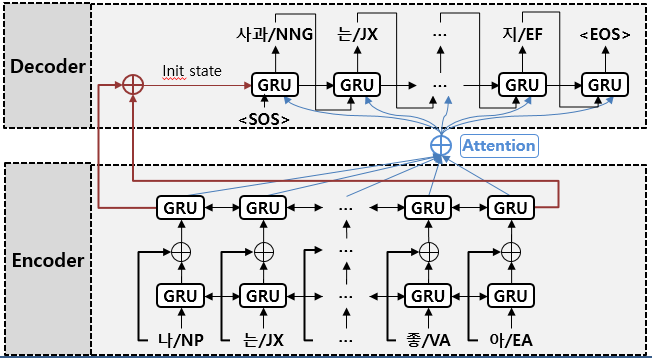

In [4]:
# assignment : Add Residual Net 
from IPython.display import Image
Image("/content/drive/My Drive/AI_assignment/w11/seq2seq_with_feature.PNG")

## model
Seq2Seq + Attention + Residual net  
Decoder + Encoder

In [5]:
# ready
import torch
import torch.nn as nn
import torch.nn.functional as F
# rnn package
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Decoder(nn.Module):
    def __init__(self, config, embedding):
        super(Decoder, self).__init__()
        
        self.embedding_size = config["embedding_size"]
        self.hidden_size = config["hidden_size"]
        self.vocab_size = config["vocab_size"]

        self.embedding = embedding
        self.dropout = nn.Dropout(config["dropout"])

        # GRU layer
        self.gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1) 
        self.linear_1 = nn.Linear(in_features=self.hidden_size*2, out_features=self.hidden_size)
        self.linear_2 = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)

    def forward(self, input, last_hidden, encoder_outputs):
        # (batch_size, 1) -> (1, batch_size, embedding_size)
        embedded = self.embedding(input).unsqueeze(0)  # (1,B,N)
        embedded = self.dropout(embedded)

        # rnn_output : (1, batch_size, hidden_size)
        # hidden : (1, batch_size, hidden_size)
        # gru -> output, hidden 나옴
        rnn_output, hidden = self.gru(embedded, last_hidden)      

        # (1, batch_size, hidden_size) -> (batch_size, 1, hidden_size)
        rnn_output_for_attention = rnn_output.transpose(0, 1).contiguous()     # 별도 메모리에 저장
        # (curr_max_length, batch_size, hidden_size) -> (batch_size, hidden_size, curr_max_length)
        encoder_outputs = encoder_outputs.permute(1, 2, 0)


        # 내적을 바탕으로 행렬곱
        # (batch_size, 1, hidden_size) -> (batch_size, 1, curr_max_length)
        attn_weights = rnn_output_for_attention.bmm(encoder_outputs)
        # (batch_size, curr_max_length) -> (batch_size, 1, curr_max_length)
        attn_weights = F.softmax(attn_weights, dim=-1)

        # (batch_size, 1, curr_max_length) * (batch_size, curr_max_length, hidden_size) 
        # -> (batch_size, 1, hidden_size)
        context = attn_weights.bmm(encoder_outputs.transpose(1, 2))

        # rnn_output : (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        # context : (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
        rnn_output, context = rnn_output.squeeze(0), context.squeeze(1)

        # (batch_size, hidden_size*2)
        concat_input = torch.cat(tensors=(rnn_output, context), dim=-1)

        # (batch_size, hidden_size*2) -> (batch_size, hidden_size)
        # linear_1 : hidden 사이즈 크기로 바꿔주는 선형함수
        concat_output = torch.tanh(self.linear_1(concat_input))

        # (batch_size, hidden_size) -> (batch_size, vocab_size)
        output = self.linear_2(concat_output)

        return output, hidden


# -------------------------------------- Encoder -------------------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, config):
        super(Seq2Seq, self).__init__()

        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.hidden_size = config["hidden_size"]
        self.max_length = config["max_length"]

        '''
        입력 데이터에 있는 각 단어 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        기존에 사전학습 된 단어 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        모델 학습 과정 중에 같이 학습 시키는 것도 가능
        예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        '''
        self.word_embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                           embedding_dim=self.embedding_size,
                                           padding_idx=0)

        # Bi-GRU layer
        self.bi_gru_1 = nn.GRU(input_size=self.embedding_size,
                             hidden_size=self.hidden_size // 2, 
                             num_layers=1,
                             bidirectional=True)
        self.bi_gru_2 = nn.GRU(input_size=(self.hidden_size),
                             hidden_size=self.hidden_size // 2, 
                             num_layers=1,
                             bidirectional=True)

        # Decoder layer
        self.decoder = Decoder(config, self.word_embedding)

        self.dropout = nn.Dropout(config["dropout"])


    def forward(self, input_features, output_features=None):
        batch_size = input_features.size()[0]

        # 입력 sequence의 실제  : 패딩이 아닌 것
        input_feature_lengths = (input_features != 0).sum(dim=-1)      # 열을 제거

        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        input_features = self.word_embedding(input_features)
        # (batch_size, max_length, embedding_size) -> (max_length, batch_size, embedding_size)
        # gru 에 넣기 위해서 차원 바꿔줌
        input_features = input_features.transpose(0, 1)

        # -------------------------------------- Add Encoder Input -------------------------------------------
        # gru1
        packed_input_features = pack_padded_sequence(input_features, input_feature_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_gru_outputs, gru_hidden_states = self.bi_gru_1(packed_input_features)
        gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs, batch_first=False)
        # (배치크기, 문장의 최대 길이, 히든크기)
        
        # gru_outputs_unpacked -> torch.Size([30, 32, 200]   [input 사이즈, 배치사이즈, hidden//2]
        # input_features -> torch.Size([52, 32, 200])    [input max 사이즈, 배치사이즈, 단어임베딩 사이즈]
        # print('gru_outputs_unpacked size :', gru_outputs_unpacked.size())     
        # print('input_features',input_features.size())
        # print('h//2',self.hidden_size // 2)

        # gru1 output + embedding  
        new_input = torch.cat([input_features, gru_outputs_unpacked], dim=0)      

        # length -> input_feature_lengths.cpu()
        final_input_features = pack_padded_sequence(new_input, input_feature_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_gru_outputs, gru_hidden_states = self.bi_gru_2(final_input_features)   
        gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs, batch_first=False)

        # (2, batch_size, hidden_size/2) -> (batch_size, hidden_size)
        gru_hidden_states = torch.cat(tensors=(gru_hidden_states[0], gru_hidden_states[1]), dim=-1)

        # gru_outputs_unpacked : (curr_max_length, batch_size, hidden_size)
        # gru_hidden_states : (batch_size, hidden_size)
        gru_outputs_unpacked, gru_hidden_states = self.dropout(gru_outputs_unpacked), self.dropout(gru_hidden_states)
        

        # -------------------------------------- Decoder Input -------------------------------------------
        # (batch_size, ), 디코더의 시작 step 입력 값을 "--START--"로 초기화
        decoder_input = torch.ones(size=(batch_size, ), dtype=torch.long).cuda()
        # (batch_size, hidden_size) -> (1, batch_size, hidden_size)
        decoder_hidden = gru_hidden_states.unsqueeze(0)    # decoder 입력넣기 위해 차원 늘림
        
        decoder_outputs = []
        
        # train
        if(output_features is not None):
            for step in range(self.max_length):
                # decoder_output : (batch_size, vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size)
                decoder_output, decoder_hidden = self.decoder(decoder_input, 
                                                              decoder_hidden, 
                                                              gru_outputs_unpacked)

                decoder_input = output_features[:, step]     # decoder outputs 을 batch size 만큼 다음 state 에 넣기 위함
                decoder_outputs.append(decoder_output)

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)    
            # 각각 분류되어 있는 리스트 형식이기 때문에 stack으로 합쳐줘야함

            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            loss_fct = nn.CrossEntropyLoss()

            # (batch_size, max_length, vocab_size) -> (batch_size*max_length, vocab_size)
            decoder_outputs = decoder_outputs.reshape(shape=(-1, self.vocab_size))
            # (batch_size, max_length) -> (batch_size*max_length)
            output_features = output_features.flatten()

            loss = loss_fct(decoder_outputs, output_features)

            return loss
        # test
        else:      
            for t in range(self.max_length):
                # decoder_output : (batch_size, vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size)
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, gru_outputs_unpacked)

                # (batch_size, vocab_size) -> (batch_size, )
                decoder_input = decoder_output.argmax(dim=-1)
                decoder_outputs.append(decoder_output.argmax(dim=-1))       
                # 분포에서 확률값이 가장 큰 것을 다음 step의 값으로 쓰기위해서 argmax 사용

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            return decoder_outputs


# Bi-GRU layer 
        self.bi_gru_1 = nn.GRU(input_size=self.embedding_size,
                             hidden_size=self.hidden_size // 2, 
                             num_layers=1,
                             bidirectional=True)
        self.bi_gru_2 = nn.GRU(input_size=(self.hidden_size),
                             hidden_size=self.hidden_size // 2, 
                             num_layers=1,
                             bidirectional=True)

gru layer는 embedding 벡터를 통과하는 gru1과, gru output + embedding 이 통과하는 gru2로 구현한다.  




# gru1 output + embedding 
`
new_input = torch.cat([input_features, gru_outputs_unpacked], dim=0) 
`　

        final_input_features = pack_padded_sequence(new_input, input_feature_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_gru_outputs, gru_hidden_states = self.bi_gru_2(final_input_features)   
        gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs, batch_first=False)



gru layer는 embedding 벡터를 통과하는 gru1과, gru output + embedding 이 통과하는 gru2로 구현한다.   

embedding 벡터와 bi_gru_1의 output을 concat 해서 bi_gru_2의 input 으로 넣는다.

# Load Data

In [6]:
import torch
import numpy as np
from tqdm import tqdm


# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 데이터의 형태가 올바른지 체크
        assert len(pieces) == 2

        # 입력 문자열을 형태소 단위로 분리
        question, answer = pieces[0].split(), pieces[1].split()

        datas.append((question, answer))

    return datas


# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    word2idx, idx2word = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        word = line.strip()
        word2idx[word] = len(word2idx)      # 사전의 길이 -> 0 부터 시작
        idx2word[word2idx[word]] = word

    print(f'\nlength of word2idx.... : {len(word2idx)}')
    print(f'\nlength of idx2word.... : {len(idx2word)}')
    return word2idx, idx2word      # '"비어플러스"가/NA': 10,   978: '4개월쫌지났는데/NA',
    # length of word2idx.... : 19353
    # length of idx2word.... : 19353


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, word2idx):
    # 입력 데이터, 출력 데이터를 담을 리스트
    input_features, output_features = [], []

    for input_sequence, output_sequence in tqdm(datas, desc="convert_data2feature"):
        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        input_feature, output_feature = np.zeros(shape=(max_length), dtype=np.int), np.zeros(shape=(max_length), dtype=np.int)

        # 입력과 출력 길이 다르기 때문에 따로 for 문 사용
        # 입력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(input_sequence[:max_length])):
            input_feature[index] = word2idx[input_sequence[index]]

        # 출력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(output_sequence[:max_length])):
            output_feature[index] = word2idx[output_sequence[index]]
        # 출력 sequence의 마지막 부분에 "--END--" 추가
        output_feature[index+1] = word2idx["--END--"]
        
        # 변환한 데이터를 각 리스트에 저장
        input_features.append(input_feature)
        output_features.append(output_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_features = torch.tensor(input_features, dtype=torch.long)
    output_features = torch.tensor(output_features, dtype=torch.long)

    return input_features, output_features      
    # 순서대로 임베딩하게됨
    # ["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA"] 
    # -> ["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞"]
    # -> [ 23, 5, 3, 5, 65, 0, 0, 0, 0, 0 ]

<h2>Model Train & Save</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, word2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Seq2Seq 모델 객체 선언</b>

<b>5. epoch를 돌때마다 모델 파일 저장</b>
</pre>

In [7]:
import os
import re
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, TensorDataset)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    # 입력 데이터 전처리
    train_input_features, train_output_features = convert_data2feature(train_datas, config["max_length"], word2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_features, train_output_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # Seq2Seq 모델 객체 생성
    model = Seq2Seq(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터 ???
            input_features, output_features = batch[0], batch[1]

            # 모델 학습
            loss = model(input_features, output_features)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값 출력
        print("Average loss : {}\n".format(np.mean(losses)))

<h2>Model Eval</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, word2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Seq2Seq 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>

<b>6. 5개의 평가 데이터에 대한 모델 출력 확인

</pre>

In [13]:
import os
from tqdm import tqdm
from torch.utils.data import (DataLoader, TensorDataset)

def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    test_input_features, test_output_features \
        = convert_data2feature(test_datas, config["max_length"], word2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_features, test_output_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # Seq2Seq 모델 객체 생성
    model = Seq2Seq(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    # model명 추가
    print('\ntrained_model :', config["trained_model_name"])

    model.eval()

    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        input_features, output_features = batch[0], batch[1]

        # 모델 평가
        predicts = model(input_features)
        predicts, input_features = predicts[0], input_features[0]

        # Tensor를 리스트로 변경
        predicts = predicts.cpu().numpy().tolist()
        input_features = input_features.cpu().numpy().tolist()

        if (step < 5):
          print()
          print("input_features : ", end=" ")
          for idx in input_features:
            word = idx2word[idx]

            if(word == "--PAD--"):
              break
            print(word, end=" ")
          print()

          print("predicts : ", end=" ")
          for idx in predicts:
            word = idx2word[idx]

            if(word == "--END--"):
              break
            print(word, end=" ")
          print()

# Main

* train

In [9]:
if(__name__=="__main__"):
    root_dir = "/content/drive/My Drive/AI_assignment/w11"
    output_dir = os.path.join(root_dir, "output")      # output

    if(not os.path.exists(output_dir)):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "trained_model_name": "epoch_{}.pt".format(75),
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "vocab_size": 19353,
              "embedding_size": 200,
              "hidden_size": 200,      # 200
              "max_length": 52,
              "epoch": 5,      # 300
              "batch_size": 32,
              "dropout": 0.3
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

convert_data2feature: 100%|██████████| 9860/9860 [00:00<00:00, 92006.75it/s]


length of word2idx.... : 19353

length of idx2word.... : 19353



epoch_2_train:   1%|          | 2/309 [00:00<00:30, 10.11it/s]

Average loss : 2.3000455843977945



epoch_3_train:   0%|          | 1/309 [00:00<00:30,  9.97it/s]

Average loss : 1.7059554432588102



epoch_4_train:   0%|          | 1/309 [00:00<00:30,  9.95it/s]

Average loss : 1.567047719430769



epoch_5_train:   0%|          | 1/309 [00:00<00:31,  9.65it/s]

Average loss : 1.4635313236211882



epoch_5_train: 100%|██████████| 309/309 [00:31<00:00,  9.71it/s]


Average loss : 1.3782431413826433



* test

In [14]:
if(__name__=="__main__"):
    root_dir = "/content/drive/My Drive/AI_assignment/w11"
    output_dir = os.path.join(root_dir, "output")      # output

    if(not os.path.exists(output_dir)):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "trained_model_name": "epoch_{}.pt".format(100),
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "vocab_size": 19353,
              "embedding_size": 200,
              "hidden_size": 200,      # 200
              "max_length": 52,
              "epoch": 5,      # 300
              "batch_size": 32,
              "dropout": 0.3
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

test:   0%|          | 0/5 [00:00<?, ?it/s]


length of word2idx.... : 19353

length of idx2word.... : 19353

trained_model : epoch_100.pt

input_features :  오늘/NNG <sp> 너무/MAG <sp> 기분/NNG 이/JKS <sp> 좋/VA 아/EC 
predicts :  오늘/NNG <sp> 밤/NNG <sp> 분/NNB 들/XSN 도/JX <sp> 좋/VA 지/EC <sp> 않/VX 는/ETM <sp> 것/NNB 이/JKS <sp> 좋/VA 다고/EC <sp> 하/VV ㅂ니다/EC 


test: 100%|██████████| 5/5 [00:00<00:00, 26.93it/s]


input_features :  내일/NNG <sp> 뭐/NNG 하/XSV 냐/EF ?/SF 
predicts :  지금/NNG <sp> 줄이/VV 지/EC <sp> 말/VX 세/EC 이/VCP 오/EF ./SF <sp> ^^/NA <sp> 이렇/VA 게/EC <sp> 생각/NNG 하/XSV 아/EC 주/VX ㄹ게요/EF ./SF <sp> 오늘/NNG <sp> 저의/NNG <sp> 컨셉/NNG 이/VCP 에요/EF ./SF <sp> 하하하/MAG <sp> ^^;;/NA 

input_features :  오늘/NNG <sp> 점심/NNG <sp> 어떤/MM 거/NNB <sp> 먹/VV 었/EP 어/EF ?/SF 
predicts :  오늘/NNG <sp> 질문/NNG 을/JKO <sp> 찾아보/VV 니/EC <sp> 하/VV 더니/EC <sp> 거/NNB <sp> 같/VA 네요/EC 

input_features :  심심/XR 하/XSA 다/EC 
predicts :  저/NP 는/JX <sp> 물건/NNG <sp> 같/VA 아요/EC 

input_features :  나/NP <sp> 감기/NNG <sp> 걸리/VV ㄴ/ETM <sp> 것/NNB <sp> 같/VA 아/EC 
predicts :  아/IC ,/SP <sp> 김현중/NNP <sp> 역시/MAJ <sp> 오세요/NNP 


# 결과
|model|epoch|train loss|
|------|---|---|
|bi GRU|100|0.27109437062130776|
|bi GRU|300|0.12463466273349466|
|bi GRU + residual net|100(1시간)|0.23914086167673462|
|bi GRU + residual net|300||
